# imports + data cleaning

In [3]:
import kagglehub
import os

# latest version of dataset
path = kagglehub.dataset_download("sonalshinde123/student-placement-dataset")

print("Path to dataset files:", path)
print(os.listdir(path))

Path to dataset files: /Users/cjz/.cache/kagglehub/datasets/sonalshinde123/student-placement-dataset/versions/1
['Student Placement Dataset']


In [5]:
import pandas as pd
import numpy as np

csv_files = [
    os.path.join(path, "Student Placement Dataset", "train.csv"),
    os.path.join(path, "Student Placement Dataset", "test.csv")
]

df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True).drop(columns=["Student_ID"]) # concat train and test .csvs from kaggle dataset; 

gender_counts = df["Gender"].value_counts()
degree_counts = df["Degree"].value_counts()
branch_counts = df["Branch"].value_counts()
placement_counts = df["Placement_Status"].value_counts()

for col in ["Gender", "Placement_Status"]:
    df[col] = df[col].astype("category").cat.codes # .cat.codes extracts integer codes of categorical col

df = pd.get_dummies(df, columns=["Degree", "Branch"], dtype=int) # one-hot encoding categorical cols

col_to_end = df.pop("Placement_Status")
df["Placement_Status"] = col_to_end # move target col to end

int64_cols = df.select_dtypes("int64").columns
df[int64_cols] = df[int64_cols].astype("int8") # save memory - converts int64 to int8
df["CGPA"] = df["CGPA"].astype("float32") # save memory - converts float64 to float32 (float16 crashes seaborn kdeplot??)

df = df.replace([np.inf, -np.inf], np.nan)
print(df.isna().sum().sum()) # count null values
df.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   50000 non-null  int8   
 1   Gender                50000 non-null  int8   
 2   CGPA                  50000 non-null  float32
 3   Internships           50000 non-null  int8   
 4   Projects              50000 non-null  int8   
 5   Coding_Skills         50000 non-null  int8   
 6   Communication_Skills  50000 non-null  int8   
 7   Aptitude_Test_Score   50000 non-null  int8   
 8   Soft_Skills_Rating    50000 non-null  int8   
 9   Certifications        50000 non-null  int8   
 10  Backlogs              50000 non-null  int8   
 11  Degree_B.Sc           50000 non-null  int8   
 12  Degree_B.Tech         50000 non-null  int8   
 13  Degree_BCA            50000 non-null  int8   
 14  Degree_MCA            50000 non-null  int8   
 15  Branch_CSE       

# EDA

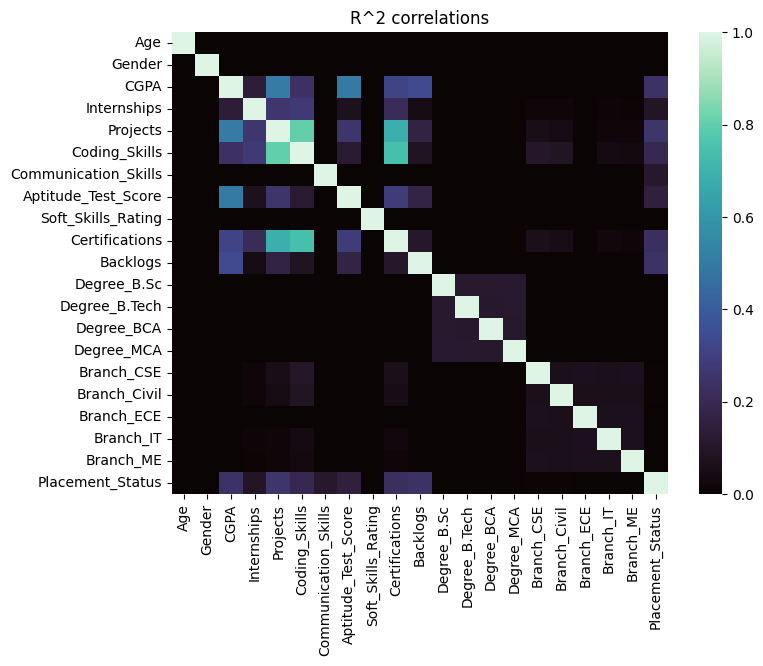

In [500]:
import matplotlib.pyplot as plt
import seaborn as sns

r_sq = df.corr(method="pearson") ** 2

plt.figure(figsize=(8,6))
sns.heatmap(r_sq, vmax=1, vmin=0, cmap="mako")
plt.title("R^2 correlations")
plt.show()

#print(list(plt.colormaps()))

Degree
B.Sc      12613
MCA       12575
B.Tech    12543
BCA       12269
Name: count, dtype: int64
Branch
ME       10038
ECE      10030
CSE       9993
IT        9983
Civil     9956
Name: count, dtype: int64
Gender
Female    25065
Male      24935
Name: count, dtype: int64
Placement_Status
Not Placed    31876
Placed        18124
Name: count, dtype: int64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


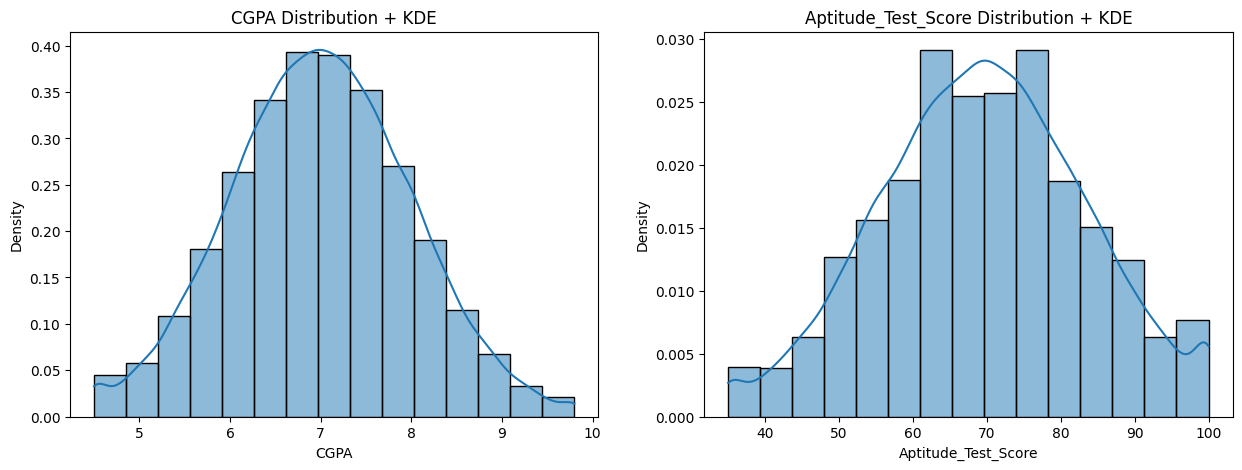

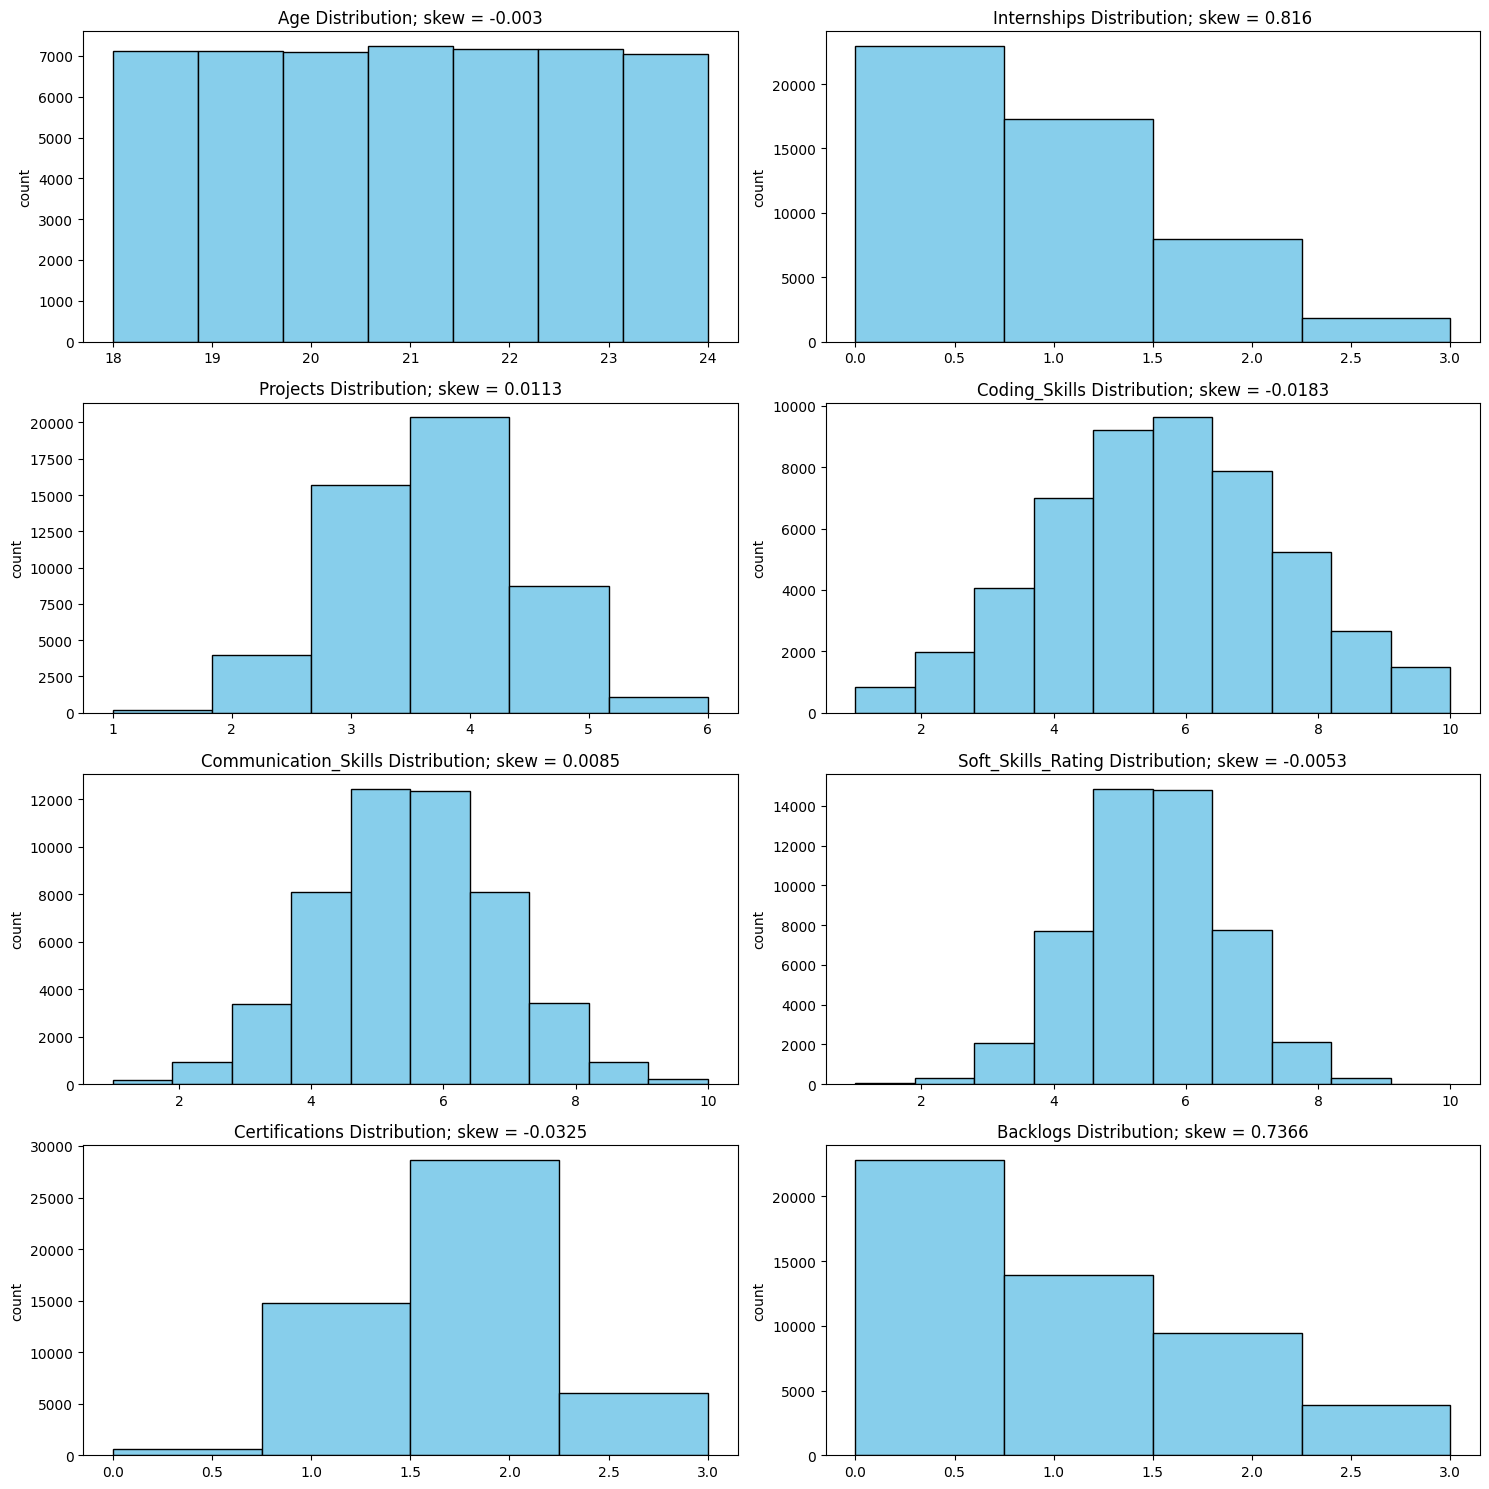

In [501]:
print(degree_counts)
print(branch_counts)
print(gender_counts)
print(placement_counts)

num_cols = ['CGPA', 'Aptitude_Test_Score']
fig, axes = plt.subplots(1, 2, figsize=(15,5))

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, bins=15, ax=axes[i], stat='density') # distribution plot
    axes[i].set_title(f'{col} Distribution + KDE')
    
# Fixed column selection
num_cols_small_range = df.columns[0:11].drop(["Gender", "CGPA", "Aptitude_Test_Score"]).tolist()

# Match subplot shape to data (6 cols → 2x3)
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
axes = axes.flatten()  # 1D array for easy indexing

for i, col in enumerate(num_cols_small_range):
    #sns.histplot(df[col], bins=df[col].nunique(), 
    #             ax=axes[i], stat='density')
    axes[i].hist(df[col], bins=df[col].nunique(), color="skyblue", edgecolor="black")
    axes[i].set_title(f'{col} Distribution; skew = {np.round(df[col].skew(), 4)}')
    axes[i].set_ylabel("count")

plt.tight_layout()
plt.show()


In [502]:
highest_placement_corr = df.corr()['Placement_Status'].sort_values(ascending=False, key=abs)[1:] # orders descending by abs value

highest_placement_corr

Projects                0.500622
Backlogs               -0.491590
CGPA                    0.490489
Certifications          0.474312
Coding_Skills           0.439541
Aptitude_Test_Score     0.389936
Communication_Skills    0.326256
Internships             0.305416
Branch_Civil           -0.085415
Branch_CSE              0.063540
Branch_IT               0.060923
Branch_ME              -0.039528
Degree_MCA              0.007462
Degree_B.Tech          -0.005719
Degree_BCA             -0.005440
Soft_Skills_Rating     -0.003814
Degree_B.Sc             0.003644
Age                     0.003295
Gender                  0.001628
Branch_ECE              0.000449
Name: Placement_Status, dtype: float64

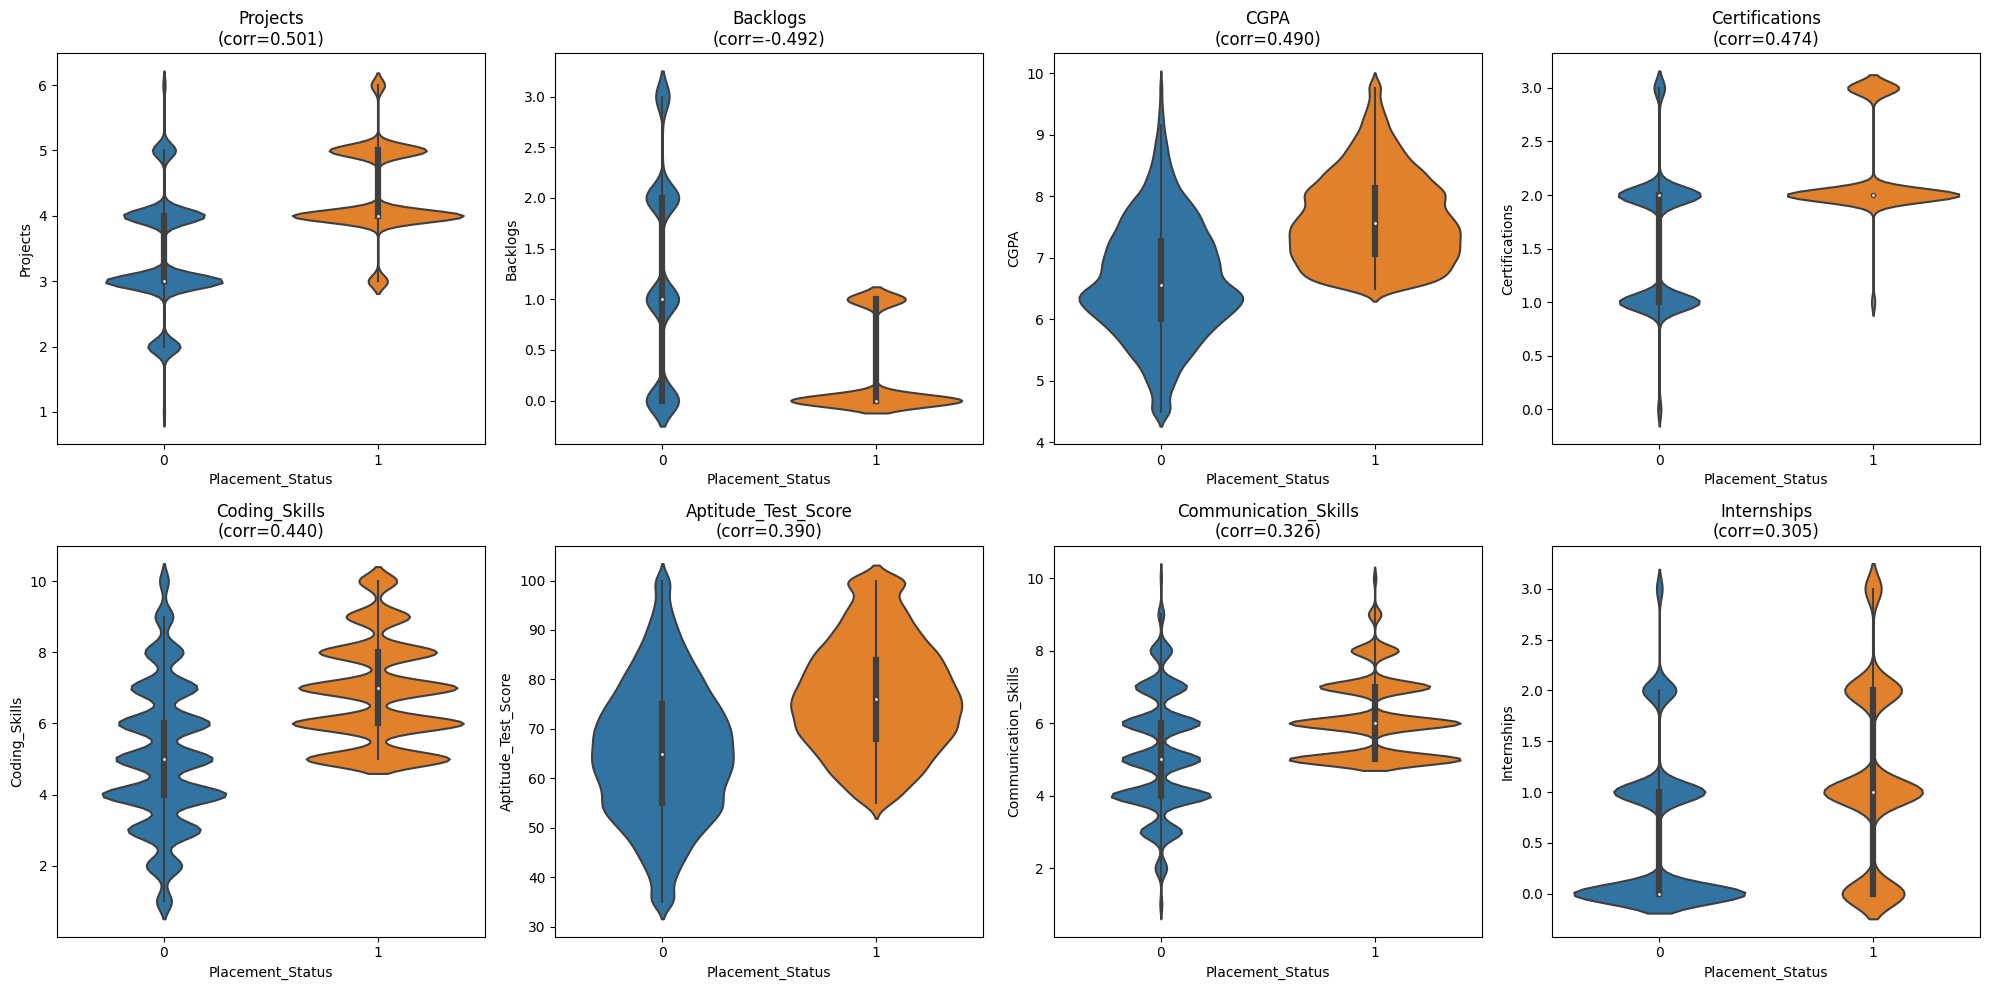

Projects
                      mean       std  min  25%  50%  75%  max
Placement_Status                                             
0                 3.387125  0.865384  1.0  3.0  3.0  4.0  6.0
1                 4.348709  0.667473  3.0  4.0  4.0  5.0  6.0


Backlogs
                      mean       std  min  25%  50%  75%  max
Placement_Status                                             
0                 1.245796  1.005541  0.0  0.0  1.0  2.0  3.0
1                 0.254028  0.435325  0.0  0.0  0.0  1.0  1.0


CGPA
                      mean       std  min   25%   50%   75%  max
Placement_Status                                                
0                 6.634787  0.936122  4.5  6.01  6.55  7.27  9.8
1                 7.649506  0.728637  6.5  7.06  7.56  8.14  9.8


Certifications
                      mean       std  min  25%  50%  75%  max
Placement_Status                                             
0                 1.569143  0.634452  0.0  1.0  2.0  2.0  3.0
1             

In [503]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()  # 1D indexing

top_feats = highest_placement_corr.head(8).index.tolist()

for i, feat in enumerate(top_feats):
    sns.violinplot(data=df, x='Placement_Status', y=feat, ax=axes[i])
    axes[i].set_title(f'{feat}\n(corr={highest_placement_corr[feat]:.3f})')

plt.tight_layout()
plt.show()

for col in top_feats:
    print(col)
    print(df.groupby('Placement_Status')[col].describe().drop("count", axis=1))
    print("\n")

In [ ]:
""" # no need for sqrt transformation bc backlogs and internships cols are discrete
skewed_cols = ["Backlogs", "Internships"]

if df["Internships"].max() - df["Internships"].min() == 3:
    df[skewed_cols] = np.round(np.sqrt(df[skewed_cols]), 3) # other option - np.log1p calculates log(1+x) so no -inf values
    
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()  # 1D array for easy indexing

for i, col in enumerate(["Backlogs", "Internships"]):
    sns.histplot(df[col], bins=10,
                 ax=axes[i], stat='count')
    axes[i].set_title(f'{col} Distribution; skew = {np.round(df[col].skew(), 3)}')

plt.tight_layout()
plt.show()
"""

# baseline model

## setup

In [507]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[df.columns[:-1]]
y = df["Placement_Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## baseline logistic reg

0.86584
[[7154  794]
 [ 883 3669]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      7948
           1       0.82      0.81      0.81      4552

    accuracy                           0.87     12500
   macro avg       0.86      0.85      0.85     12500
weighted avg       0.87      0.87      0.87     12500



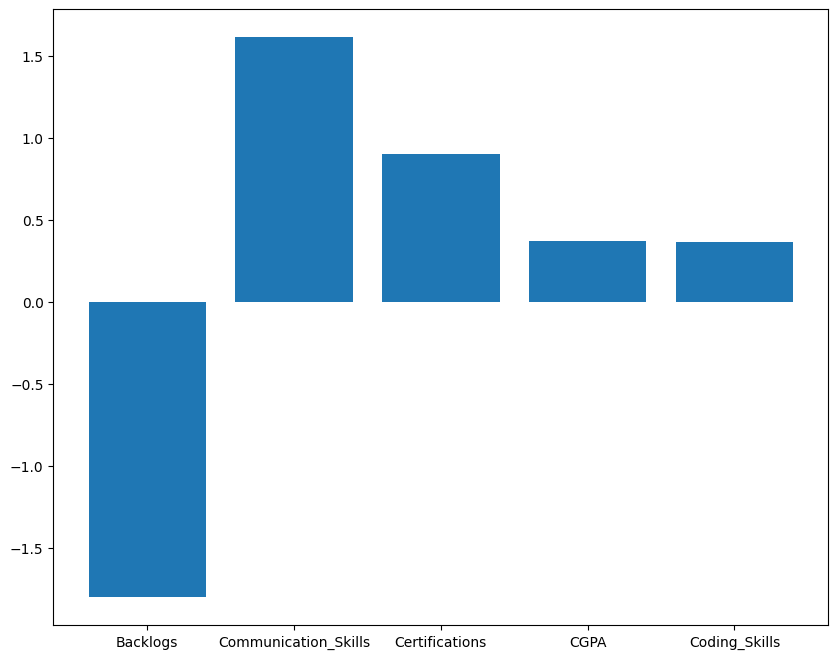

{'Backlogs': -1.80287,
 'Communication_Skills': 1.61549,
 'Certifications': 0.90125,
 'CGPA': 0.36925,
 'Coding_Skills': 0.36513}

In [554]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

coefs = np.round(lr.coef_[0], 5)
feature_names = df.columns[:-1]

# get indices of top 8 absolute values
top_indices = np.argsort(np.abs(coefs))[-5:][::-1] # argsort gets indices of top 8 values; [::-1] sorts in descending order
top_5 = dict(zip(feature_names[top_indices], coefs[top_indices]))

plt.figure(figsize=(10,8))
plt.bar(x=feature_names[top_indices], height=coefs[top_indices], width=0.8)
plt.show()

top_5

## baseline random forest

[LibSVM]..........................................................................................................*...........................*....................................................................*........................*
optimization finished, #iter = 225488
obj = -12334.954043, rho = -1.143000
nSV = 12351, nBSV = 12326
Total nSV = 12351
0.86944
[[7128  820]
 [ 812 3740]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      7948
           1       0.82      0.82      0.82      4552

    accuracy                           0.87     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.87      0.87      0.87     12500



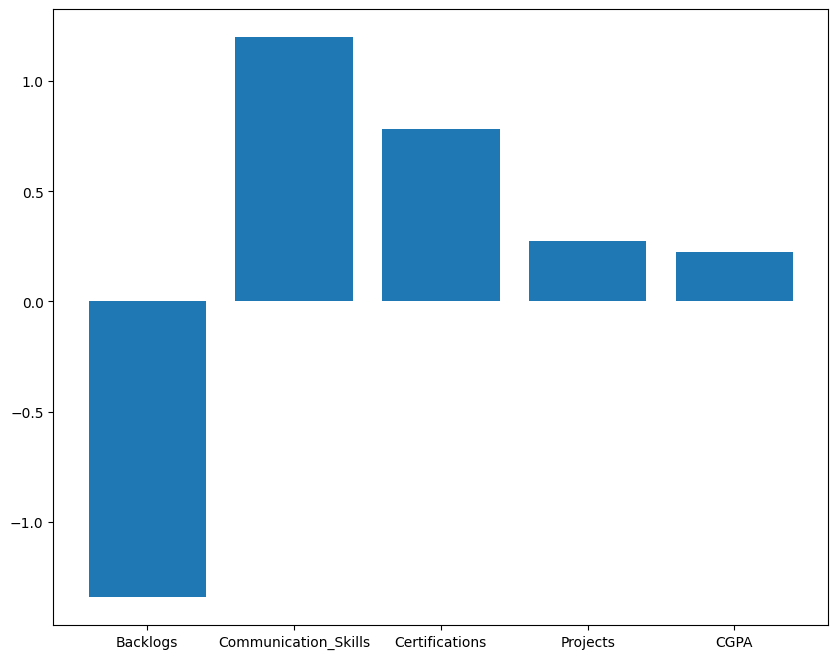

{'Backlogs': -1.34083,
 'Communication_Skills': 1.19859,
 'Certifications': 0.78378,
 'Projects': 0.27611,
 'CGPA': 0.2248}

In [ ]:
from sklearn.svm import SVC

svc = SVC(kernel="linear")
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

coefs = np.round(svc.coef_[0], 5)
feature_names = df.columns[:-1]

# get indices of top 8 absolute values
top_indices = np.argsort(np.abs(coefs))[-5:][::-1] # argsort gets indices of top 8 values; [::-1] sorts in descending order
top_5 = dict(zip(feature_names[top_indices], coefs[top_indices]))

plt.figure(figsize=(10,8))
plt.bar(x=feature_names[top_indices], height=coefs[top_indices])
plt.show()
top_5